In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


In [2]:
import numpy as np
import torch
# MNIST dataset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
    
def define_dataloaders(n_examples_train, n_examples_test, batch_size, classes=np.arange(10), zscore_images=True):
    # MNIST data, batch training
    #batch_size = n_examples_train

    # Choose the classes (at most 10)
    assert max(classes) <= 9

    # Transformation for the images
    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,)),
                                  ])
    trainset = MNIST(data_dir, download=True, train=True, transform=transform)
    testset = MNIST(data_dir, download=True, train=False, transform=transform)

    # Obtain training and test data. 
    # Note that both datasets are sorted, but the train and test loaders will shuffle them during training.
    n_examples_tt = [n_examples_train, n_examples_test]
    for i_d, (n_examples_i, dataset) in enumerate(zip(n_examples_tt, [trainset, testset])):
        n_per_class = n_examples_i // len(classes)
        data_orig = dataset.data.detach().clone()
        targets_orig = dataset.targets.detach().clone()
        for i_c, class_i in enumerate(classes):
            mask = targets_orig == class_i
            i0 = i_c * n_per_class
            i1 = (i_c+1) * n_per_class
            dataset.data[i0:i1] = data_orig[mask][:n_per_class]
            dataset.targets[i0:i1] = targets_orig[mask][:n_per_class]
        # Fill the remaining slots with random classes from the available choices
        n_remain = n_examples_i - i1 
        for i in range(n_remain):
            class_i = np.random.choice(classes)
            mask = targets_orig == class_i
            idx_i = np.random.choice(torch.where(mask)[0].cpu())
            dataset.data[i1+i] = data_orig[idx_i]
            dataset.targets[i1+i] = targets_orig[idx_i]

        # Cut off
        dataset.data = dataset.data[:n_examples_i]
        dataset.targets = dataset.targets[:n_examples_i]

    # Batch-loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=n_examples_test, shuffle=False, num_workers=0)

    return trainloader, testloader

## Settings:
- no dropout
- no momentum
- increased number of fetures/filters

In [3]:
learning_rate = 0.01
momentum = 0
n_epochs = 100
log_interval = 10

In [4]:
#Building the Network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 60, kernel_size=5)
        self.conv2 = nn.Conv2d(60, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = torch.tanh(F.max_pool2d(self.conv1(x), 2))
        x = torch.tanh(F.max_pool2d((self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
loss_f=nn.CrossEntropyLoss()

In [6]:
data_dir = '/files/'
batch_size = 64
n_examples_train = 4*batch_size
n_examples_test = 1024
train_loader, test_loader =  define_dataloaders(n_examples_train, n_examples_test, batch_size)

train_losses = []
train_accuracy = []
train_counter = []
test_losses = []
test_accuracy = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [7]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = loss_f(output,target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
  
  correct = 0
  with torch.no_grad():
    for data, target in train_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  train_accuracy.append(100. * correct / len(train_loader.dataset))

In [8]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_f(output,target)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader)
  test_losses.append(test_loss)
  test_accuracy.append(100. * correct / len(test_loader.dataset))


In [9]:
test()
for epoch in tqdm(range(1, n_epochs + 1)):
  train(epoch)
  test()

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Text(0, 0.5, 'loss')

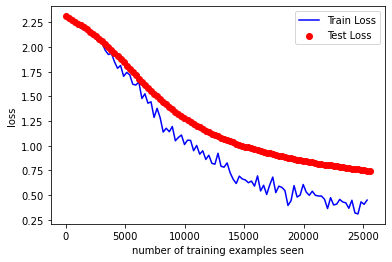

In [10]:
# LOSS
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')

In [11]:
train_losses

[2.3057119846343994,
 2.294668436050415,
 2.283629894256592,
 2.2507753372192383,
 2.2227916717529297,
 2.1894633769989014,
 2.1771864891052246,
 2.15394926071167,
 2.1341631412506104,
 2.1067709922790527,
 2.077629327774048,
 2.0536718368530273,
 2.0343239307403564,
 1.9652481079101562,
 1.9247654676437378,
 1.9366799592971802,
 1.8506641387939453,
 1.7852288484573364,
 1.813330054283142,
 1.7038506269454956,
 1.7428410053253174,
 1.7198151350021362,
 1.6236213445663452,
 1.6149811744689941,
 1.6459026336669922,
 1.4791710376739502,
 1.5263444185256958,
 1.4309468269348145,
 1.4454718828201294,
 1.2870944738388062,
 1.3787614107131958,
 1.283925175666809,
 1.1388956308364868,
 1.1771208047866821,
 1.1422967910766602,
 1.1943241357803345,
 1.0499175786972046,
 1.0844236612319946,
 1.1086070537567139,
 1.012062430381775,
 1.0565446615219116,
 1.0538603067398071,
 0.9494262933731079,
 1.0028176307678223,
 0.9142012000083923,
 0.9488357305526733,
 0.8608335852622986,
 0.9039016366004944,


Text(0, 0.5, 'loss')

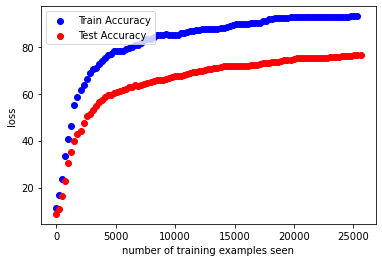

In [12]:
# ACCURACY

fig = plt.figure()
plt.scatter(test_counter[:-1], train_accuracy, color='blue', zorder=1)
plt.scatter(test_counter, test_accuracy, color='red', zorder=2)
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.xlabel('number of training examples seen')
plt.ylabel('Accuracy')

In [13]:
for i,_ in enumerate(train_accuracy):
    print(test_accuracy[i+1] - train_accuracy[i])

tensor(-0.3906)
tensor(-0.2930)
tensor(-0.8789)
tensor(-2.9297)
tensor(-5.2734)
tensor(-6.4453)
tensor(-12.3047)
tensor(-14.5508)
tensor(-14.0625)
tensor(-13.3789)
tensor(-15.0391)
tensor(-15.8203)
tensor(-15.6250)
tensor(-14.4531)
tensor(-15.4297)
tensor(-15.4297)
tensor(-15.8203)
tensor(-17.0898)
tensor(-16.6992)
tensor(-17.3828)
tensor(-17.1875)
tensor(-16.6992)
tensor(-16.1133)
tensor(-16.2109)
tensor(-16.4062)
tensor(-16.6016)
tensor(-17.5781)
tensor(-17.1875)
tensor(-17.6758)
tensor(-18.3594)
tensor(-18.1641)
tensor(-17.7734)
tensor(-18.3594)
tensor(-19.1406)
tensor(-19.1406)
tensor(-18.9453)
tensor(-18.9453)
tensor(-18.1641)
tensor(-17.6758)
tensor(-17.5781)
tensor(-17.4805)
tensor(-17.9688)
tensor(-17.4805)
tensor(-17.4805)
tensor(-17.6758)
tensor(-17.3828)
tensor(-17.5781)
tensor(-17.3828)
tensor(-17.5781)
tensor(-17.1875)
tensor(-17.0898)
tensor(-16.6016)
tensor(-16.4062)
tensor(-16.3086)
tensor(-16.0156)
tensor(-16.0156)
tensor(-16.6016)
tensor(-16.8945)
tensor(-17.1875)
ten

In [14]:
test_accuracy

[tensor(8.7891),
 tensor(10.9375),
 tensor(16.5039),
 tensor(22.9492),
 tensor(30.6641),
 tensor(35.3516),
 tensor(39.6484),
 tensor(42.7734),
 tensor(44.0430),
 tensor(47.6562),
 tensor(50.2930),
 tensor(51.3672),
 tensor(52.9297),
 tensor(54.6875),
 tensor(56.6406),
 tensor(57.2266),
 tensor(58.3984),
 tensor(59.5703),
 tensor(59.4727),
 tensor(60.2539),
 tensor(60.7422),
 tensor(60.9375),
 tensor(61.4258),
 tensor(62.0117),
 tensor(62.6953),
 tensor(62.8906),
 tensor(63.4766),
 tensor(63.2812),
 tensor(63.6719),
 tensor(63.9648),
 tensor(64.4531),
 tensor(65.0391),
 tensor(65.4297),
 tensor(65.6250),
 tensor(66.0156),
 tensor(66.0156),
 tensor(66.2109),
 tensor(66.6016),
 tensor(66.9922),
 tensor(67.4805),
 tensor(67.5781),
 tensor(67.6758),
 tensor(67.9688),
 tensor(68.4570),
 tensor(68.8477),
 tensor(69.0430),
 tensor(69.3359),
 tensor(69.5312),
 tensor(69.7266),
 tensor(69.9219),
 tensor(70.3125),
 tensor(70.4102),
 tensor(70.8984),
 tensor(71.0938),
 tensor(71.1914),
 tensor(71.

In [15]:
train_accuracy

[tensor(11.3281),
 tensor(16.7969),
 tensor(23.8281),
 tensor(33.5938),
 tensor(40.6250),
 tensor(46.0938),
 tensor(55.0781),
 tensor(58.5938),
 tensor(61.7188),
 tensor(63.6719),
 tensor(66.4062),
 tensor(68.7500),
 tensor(70.3125),
 tensor(71.0938),
 tensor(72.6562),
 tensor(73.8281),
 tensor(75.3906),
 tensor(76.5625),
 tensor(76.9531),
 tensor(78.1250),
 tensor(78.1250),
 tensor(78.1250),
 tensor(78.1250),
 tensor(78.9062),
 tensor(79.2969),
 tensor(80.0781),
 tensor(80.8594),
 tensor(80.8594),
 tensor(81.6406),
 tensor(82.8125),
 tensor(83.2031),
 tensor(83.2031),
 tensor(83.9844),
 tensor(85.1562),
 tensor(85.1562),
 tensor(85.1562),
 tensor(85.5469),
 tensor(85.1562),
 tensor(85.1562),
 tensor(85.1562),
 tensor(85.1562),
 tensor(85.9375),
 tensor(85.9375),
 tensor(86.3281),
 tensor(86.7188),
 tensor(86.7188),
 tensor(87.1094),
 tensor(87.1094),
 tensor(87.5000),
 tensor(87.5000),
 tensor(87.5000),
 tensor(87.5000),
 tensor(87.5000),
 tensor(87.5000),
 tensor(87.8906),
 tensor(87

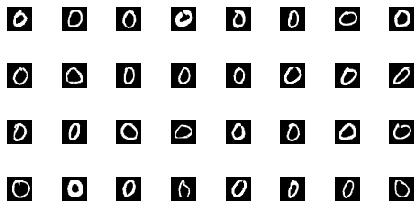

In [16]:
fig = plt.figure()
i=0
for data, target in test_loader:
    j=0
for i in range(32):
    ax = fig.add_subplot(4,8,i+1)
    ax.imshow(data[i][0], cmap='gray', interpolation='none')
    plt.tight_layout()
    ax.axis('off')


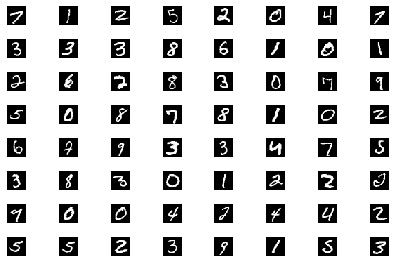

In [17]:
fig = plt.figure()
i=0
for data, target in train_loader:
    j=0
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(data[i][0], cmap='gray', interpolation='none')
    plt.tight_layout()
    ax.axis('off')


In [18]:
for batch_idx, (data, target) in enumerate(test_loader):
    print(batch_idx)


0


In [19]:
data.size()

torch.Size([1024, 1, 28, 28])